In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from math import floor


import json
from pprint import pprint

In [2]:
json_path="./data_balancers_border_mandelbrot.json"
with open(json_path) as f:
    data = json.load(f)

In [9]:
prediction = []
naive = []

for d in data["datapoints"]:
    s = d["setting"]
    comp_time = list(map(lambda x: x["computationTime"],
                   d["data"]["workers"]))
    if s["balancer"] == "predictionRecursive":
        prediction += comp_time
    elif s["balancer"] == "naiveRecursive":
        naive += comp_time
     

# time in s
prediction = np.asarray(prediction) / 1e6
naive = np.asarray(naive) / 1e6
print(timings, naive)

[ 0.031609  0.043638  0.044913  0.044896  0.054412  0.066634  0.067615
  0.07177   0.068849  0.067257  0.067412  0.073289  0.071439  0.072466
  0.101234  0.107665  0.094623  0.088066  0.076126  5.5839    7.294815
  7.360869  7.662697  7.727647  7.811481  8.276613  9.036667  9.532818
  9.801055  9.968632 10.936509 10.920365 11.171365 11.191542 13.044784
 14.521841 15.577968 17.333996  5.261922  8.030265  8.042974 10.355693
 10.673556 12.031984 12.262536 13.051566 13.237628 14.289071 15.334311
 16.034415 16.048858 17.164737 17.234098 17.50167  22.039109 23.126055
 24.072345  3.035337  5.184961  5.288183  5.388039  6.60748   8.007482
  8.029643  8.242183  8.605546  9.086274  9.526796 10.410857 10.657179
 10.801609 10.795646 12.49076  15.955091 17.248833 19.474098  5.462538
  7.196936  7.298429  7.664392  7.726323  7.818946  8.271738  9.034657
  9.536976  9.590884  9.967186 10.931493 10.929179 10.937118 10.958591
 13.042757 14.522653 15.578994 17.330743  5.26126   8.02785   8.040967
 10.35

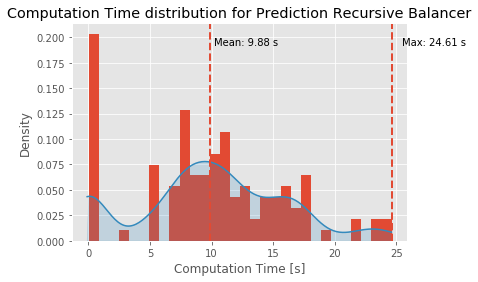

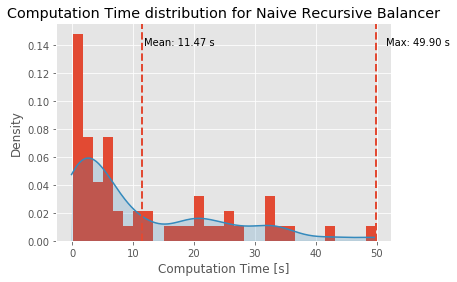

In [30]:
# Data for plotting
def histogram(y_data, x_label, y_label, title):
    num_bins = 30
    plt.style.use('ggplot')
    fig, ax = plt.subplots()

    # draw histogram
    n, bins, patches = ax.hist(y_data, num_bins, density= 1)
    # ax.legend()
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(True)

    # plot kernel density estimate
    density = gaussian_kde(y_data)
    xs = np.linspace(-0.1, y_data.max(), 200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    ys = density(xs)

    kde_line = ax.plot(xs, ys)
    # TODO: Find a better way to do this
    ys[0] = 0
    ys[-1] = 0
    kde_fill = ax.fill(xs, ys, alpha=.2)
    kde_fill[0].set_color(kde_line[0].get_color())

    #  median
    ax.axvline(y_data.mean(), linestyle='dashed', linewidth=2)
    _, max_ = plt.ylim()
    plt.text(y_data.mean() + y_data.mean() / num_bins, 
             max_ - max_ / 10, 
             'Mean: {:.2f} s'.format(y_data.mean()))
    #  max
    ax.axvline(y_data.max(), linestyle='dashed', linewidth=2)
    _, max_ = plt.ylim()
    plt.text(y_data.max() + y_data.max() / num_bins, 
             max_ - max_ / 10, 
             'Max: {:.2f} s'.format(y_data.max()))

    # fig.savefig("distribution.svg", format="svg")
    plt.show()
    
histogram(prediction, 
         x_label='Computation Time [s]',
         y_label='Density',
         title='Computation Time distribution for Prediction Recursive Balancer')
histogram(naive, 
         x_label='Computation Time [s]',
         y_label='Density',
         title='Computation Time distribution for Naive Recursive Balancer')

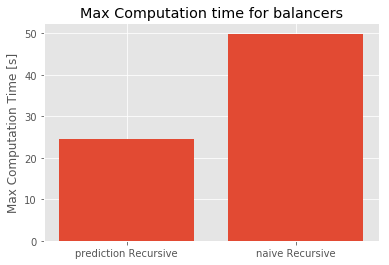

In [28]:
names= ["prediction Recursive", "naive Recursive"]
y = np.asarray([prediction.max(), naive.max()])
x = np.arange(len(y))

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set(ylabel='Max Computation Time [s]',
      title='Max Computation time for balancers')
ax.grid(True)
plt.show()

In [ ]:
a